In [3]:
import earthaccess
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# 1) Log in
earthaccess.login()

# 2) Define your time span and bounding box
tspan = ("2024-08-29", "2024-10-24")
west, south, east, north = (-85.469669, 24.254477, -80.897385, 29.159357)

# 3) Search for the 8-day IOP backscatter granules
results_bb = earthaccess.search_data(
    short_name    = "PACE_OCI_L3M_IOP",
    granule_name  = "*.8D.*bbp_442.4km.*",
    temporal      = tspan,
    bounding_box  = (west, south, east, north),
)
bb_paths = earthaccess.open(results_bb)



QUEUEING TASKS | :   0%|          | 0/8 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/8 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/8 [00:00<?, ?it/s]

In [4]:


# 4) Preprocess: inject `time` from attrs and subset
def preprocess(ds):
    # extract the ISO timestamp, drop the trailing 'Z'
    t0 = ds.attrs["time_coverage_start"].rstrip("Z")
    # assign it as a numpy datetime64 coordinate
    ds = ds.assign_coords(time=np.datetime64(t0))
    # spatially subset
    lat_asc = bool(ds.lat[1] > ds.lat[0])
    lat_slice = slice(south, north) if lat_asc else slice(north, south)
    ds = ds.sel(lon=slice(west, east), lat=lat_slice)
    # keep just bbp_442
    return ds[["bbp_442"]]

# 5) Open & concatenate with that preprocess
ds = xr.open_mfdataset(
    bb_paths,
    combine     = "nested",
    concat_dim  = "time",
    preprocess  = preprocess,
    data_vars   = "minimal",
    coords      = "minimal",
    chunks      = {'time':1, 'lat':128, 'lon':128},
    parallel    = True,
)

print("Dimensions after open_mfdataset:", ds.dims)
# should now show 'time': ~7–8, plus lat & lon

# 6) Build your 1-D time series
bb_ts = ds["bbp_442"].mean(dim=("lat", "lon")).compute()




/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/_task_spec.py:758: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 128. This could degrade performance. Instead, consider rechunking after loading.
  return self.func(*new_argspec, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/_task_spec.py:758: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 128. This could degrade performance. Instead, consider rechunking after loading.
  return self.func(*new_argspec, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/_task_spec.py:758: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 128. This could degrade performance. Instead, consider rechunking after loading.
  return self.func(*new_argspec, **kwargs)
/srv/conda/envs/notebook/lib/python3.11/site-packages/dask/_task_spec.py:758: UserWarning: 

Dimensions after open_mfdataset: FrozenMappingWarningOnValuesAccess({'time': 8, 'lat': 118, 'lon': 109})


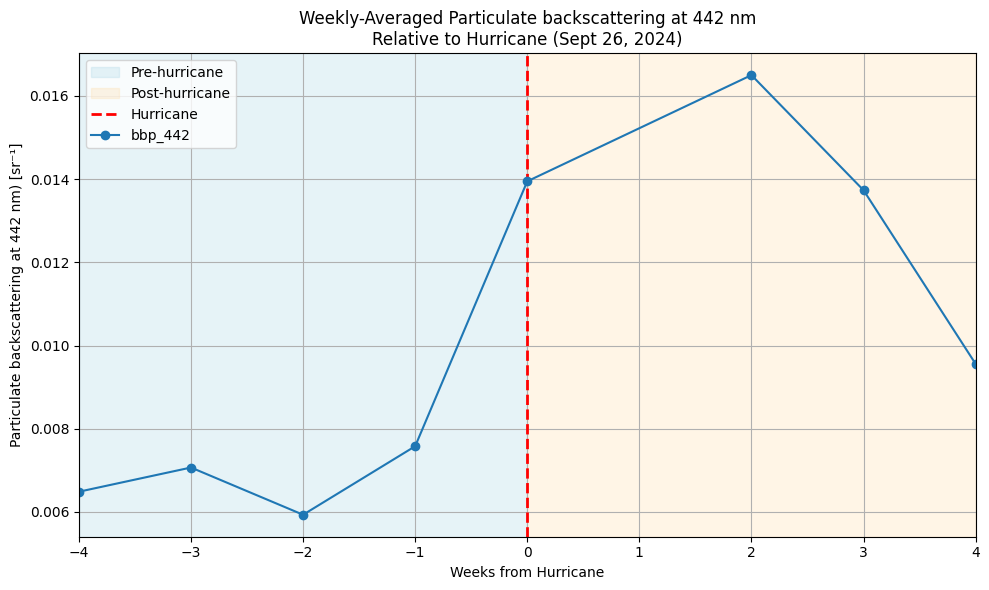

In [7]:


#) Extract the time coordinate and values
times = bb_ts["time"].values                                      # e.g. array(['2024-08-29T00:00:00', ...], dtype='datetime64[ns]')
bb_vals = bb_ts.values                                             # shape (n_times,)

#  Compute weeks relative to Sept 26, 2024
hurricane = np.datetime64("2024-09-26T00:00:00")
# difference in days, then divide by 7 and round to nearest integer
weeks = np.round((times - hurricane) / np.timedelta64(1, "W")).astype(int)


# Determine xmin/xmax
xmin, xmax = weeks.min(), weeks.max()

fig, ax = plt.subplots(figsize=(10,6))

# Pre‐hurricane: from xmin to 0
ax.axvspan(xmin, 0,
           color="lightblue", alpha=0.3, label="Pre-hurricane")

# Post‐hurricane: from 0 to xmax
ax.axvspan(0, xmax,
           color="navajowhite", alpha=0.3, label="Post-hurricane")

# Hurricane line
ax.axvline(0, color="red", linestyle="--", linewidth=2, label="Hurricane")

# Data line
ax.plot(weeks, bb_vals,
        marker="o", linestyle="-",
        color="tab:blue", label="bbp_442")

# Obligate the x-axis exactly to [xmin, xmax]
ax.set_xlim(xmin, xmax)

# Labeling+Legends
ax.set_xlabel("Weeks from Hurricane")
ax.set_ylabel("Particulate backscattering at 442 nm) [sr⁻¹]")
ax.set_title("Weekly-Averaged Particulate backscattering at 442 nm\nRelative to Hurricane (Sept 26, 2024)")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()



